В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
medical_df = pd.read_csv('medical-charges.csv') 
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [3]:
non_smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


In [4]:
X = non_smoker_df['age'].values
y = non_smoker_df['charges'].values
X_matrix = np.c_[np.ones(X.shape[0]), X]

In [5]:
# МНК: β = (XᵀX)^(-1)Xᵀy
beta_ls = np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ y
y_pred_ls = X_matrix @ beta_ls

# RMSE
rmse_ls = np.sqrt(np.mean((y - y_pred_ls) ** 2))
print("МНК Coefficients:", beta_ls)
print("МНК RMSE:", rmse_ls)

МНК Coefficients: [-2091.42055657   267.24891283]
МНК RMSE: 4662.505766636395


In [6]:
#Full-Batch
def gradient_descent(X, y, lr=0.01, epochs=1000):
    m = len(y)
    beta = np.zeros(X.shape[1])
    rmse_list = []

    for i in range(epochs):
        y_pred = X @ beta
        error = y_pred - y
        gradient = (2/m) * (X.T @ error)
        beta -= lr * gradient
        rmse = np.sqrt(np.mean(error ** 2))
        rmse_list.append(rmse)

    return beta, rmse_list

learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    beta_gd, rmse_history = gradient_descent(X_matrix, y, lr=lr, epochs=1000)
    y_pred_gd = X_matrix @ beta_gd
    final_rmse = np.sqrt(np.mean((y - y_pred_gd) ** 2))
    results[lr] = {
        'beta': beta_gd,
        'rmse': final_rmse,
        'rmse_history': rmse_history,
        'predictions': y_pred_gd
    }
    print(f"GD lr={lr} - Coefficients: {beta_gd}, RMSE: {final_rmse}")


GD lr=0.01 - Coefficients: [nan nan], RMSE: nan
GD lr=0.001 - Coefficients: [nan nan], RMSE: nan
GD lr=0.0001 - Coefficients: [-41.98126853 221.10458438], RMSE: 4713.250582815521


/tmp/ipykernel_11747/3776927803.py:12: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean(error ** 2))
/home/liubov/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_11747/3776927803.py:10: RuntimeWarning: overflow encountered in matmul
  gradient = (2/m) * (X.T @ error)
/tmp/ipykernel_11747/3776927803.py:11: RuntimeWarning: invalid value encountered in subtract
  beta -= lr * gradient


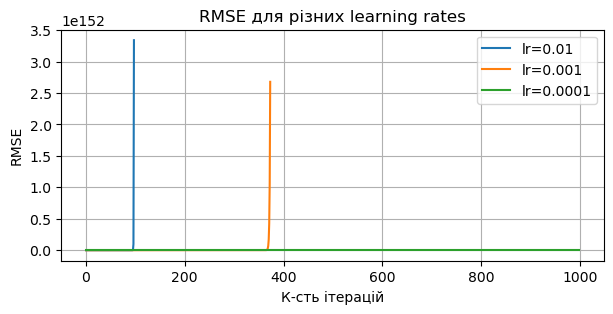

In [7]:
plt.figure(figsize=(7, 3))
for lr in learning_rates:
    plt.plot(results[lr]['rmse_history'], label=f'lr={lr}')
plt.xlabel("К-сть ітерацій")
plt.ylabel("RMSE")
plt.title("RMSE для різних learning rates")
plt.legend()
plt.grid()
plt.show()


Результати nan в коефіцієнтах i RMSE (та попередження про overflow) говорять про те, що градієнтний спуск різко набуває занадто великих значень. Спробуємо нормалізувати дані:

In [8]:
# Нормалізація даних
X_mean = X.mean()
X_std = X.std()
X_scaled = (X - X_mean) / X_std

X_matrix_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

In [9]:
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    beta_gd, rmse_history = gradient_descent(X_matrix_scaled, y, lr=lr, epochs=1000)
    y_pred_gd = X_matrix_scaled @ beta_gd
    final_rmse = np.sqrt(np.mean((y - y_pred_gd) ** 2))
    results[lr] = {
        'beta_scaled': beta_gd,
        'rmse': final_rmse,
        'rmse_history': rmse_history,
        'predictions': y_pred_gd
    }
    print(f"GD lr={lr}  Coefficients (scaled): {beta_gd}, RMSE: {final_rmse}")

GD lr=0.01  Coefficients (scaled): [8434.26828366 3762.00690212], RMSE: 4662.505766636395
GD lr=0.001  Coefficients (scaled): [7295.09787802 3253.89324192], RMSE: 4826.473740471969
GD lr=0.0001  Coefficients (scaled): [1529.01158762  681.99776822], RMSE: 8883.016748944528


In [10]:
# Відновлення коефіцієнтів у вихідному масштабі
best_lr = min(results, key=lambda lr: results[lr]['rmse'])
beta_scaled = results[best_lr]['beta_scaled']

# Формула для зворотного масштабування:
# y = β0 + β1 * (x - mean) / std = (β1/std)*x + (β0 - β1*mean/std)
beta_1_original = beta_scaled[1] / X_std
beta_0_original = beta_scaled[0] - (beta_scaled[1] * X_mean / X_std)
print(f"\nBest GD lr: {best_lr}")
print(f"Recovered Coefficients: intercept = {beta_0_original}, slope = {beta_1_original}")


Best GD lr: 0.01
Recovered Coefficients: intercept = -2091.4205530453, slope = 267.24891238142857


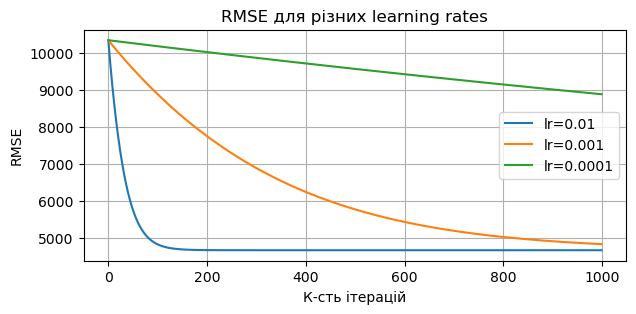

In [11]:
plt.figure(figsize=(7, 3))
for lr in learning_rates:
    plt.plot(results[lr]['rmse_history'], label=f'lr={lr}')
plt.xlabel("К-сть ітерацій")
plt.ylabel("RMSE")
plt.title("RMSE для різних learning rates")
plt.legend()
plt.grid()
plt.show()

1) `lr=0.01`: Бачимо швидке зменшення RMSE. Збіжність до стабільного значення десь після ~200 ітерацій. Це найкращий learning rate серед трьох. Оптимальний вибір для цієї задачі.

2) `lr=0.001`: У цьому випадку RMSE зменшується повільніше. Збіжність не така швидка і досягається при значеннях значно більших за 1000. В цілому непоганий варіант, але повільний.

3) `lr=0.0001`: RMSE зменшується дуже повільно. За 1000 ітерацій навіть не наблизився до мінімуму.
Занадто малий learning rate для цієї задачі.

In [12]:
# Scikit-learn LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X.reshape(-1, 1), y)

y_pred_skl = model.predict(X.reshape(-1, 1))
rmse_skl = np.sqrt(mean_squared_error(y, y_pred_skl))

print("Sklearn Coefficients:", [model.intercept_, model.coef_[0]])
print("Sklearn RMSE:", rmse_skl)

Sklearn Coefficients: [-2091.4205565650864, 267.2489128311997]
Sklearn RMSE: 4662.505766636395


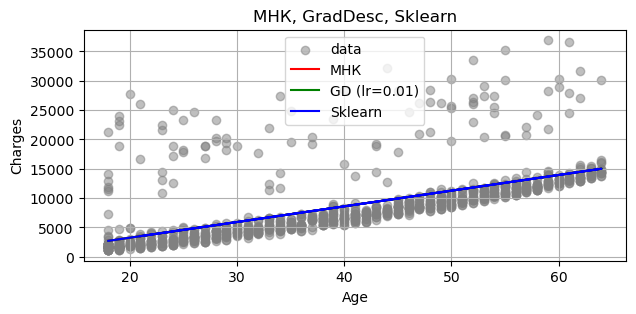

In [13]:
plt.figure(figsize=(7, 3))
plt.scatter(X, y, color='gray', label='data', alpha=0.5)

plt.plot(X, y_pred_ls, label='МНК', color='red')
best_lr = min(results, key=lambda lr: results[lr]['rmse'])
plt.plot(X, results[best_lr]['predictions'], label=f'GD (lr={best_lr})', color='green')
plt.plot(X, y_pred_skl, label='Sklearn', color='blue')

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("МНК, GradDesc, Sklearn")
plt.legend()
plt.grid()
plt.show()


**Висновки**
- RMSE для трьох підходів практично однаковий.
- Всі моделі майже ідентично апроксимують дані, що логічно, адже це проста лінійна задача з одним предиктором і достатньо даних.

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
#дані з курцями
medical_df = pd.read_csv('medical-charges.csv')
smoker_df = medical_df[medical_df.smoker == 'yes']

X = smoker_df['age'].values.reshape(-1, 1)
y = smoker_df['charges'].values

In [16]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [17]:
y_pred = model.predict(X)

In [18]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("Коефіцієнти моделі:")
print("  Intercept beta_0:", model.intercept_)
print("  Slope beta_1:", model.coef_[0])
print(f"\nТочність моделі:")
print(f"  RMSE: {rmse:.2f}")
print(f"  R^2: {r2:.4f}")

Коефіцієнти моделі:
  Intercept beta_0: 20294.128126915966
  Slope beta_1: 305.2376021098288

Точність моделі:
  RMSE: 10711.00
  R^2: 0.1356


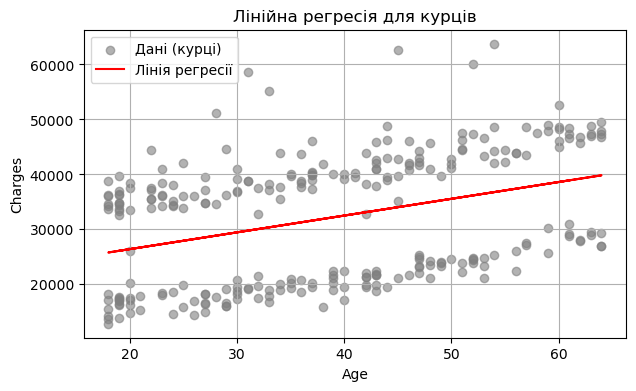

In [30]:
plt.figure(figsize=(7, 4))
plt.scatter(X, y, color='grey', label='Дані (курці)', alpha=0.6)

plt.plot(X, y_pred, color='red', label='Лінія регресії')
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Лінійна регресія для курців")
plt.legend()
plt.grid()
plt.show()


**Висновки**

1) `Intercept` = 20294.13
Це означає, що умовно середній курець віком 0 років має витрати близько 20294 дол.
Очевидно, що це не має фізичного сенсу і було б добре накладати якісь обмеження на модель.
3) `Slope` = 305.24. На кожен рік збільшуються прогнозовані витрати на ~305 дол. Це логічно (з віком витрати на здоров'я збільшуються).
4) `RMSE` = 10,711. Це середня похибка прогнозу. Це дуже велика похибка, особливо якщо врахувати, що `charges` - від 10К до 50К доларів.
5) `R^2` = 0.1356. Це дуже низьке значення.
6) Отже, лінійна модель не підходить для реального прогнозування. Можливо, варто спробувати більш складну модель (щоб врахувати й інші фічі bmi, sex, region, children). Або розбити курців на підгрупи.

### Перевірка гіпотези про розбиття на підгрупи

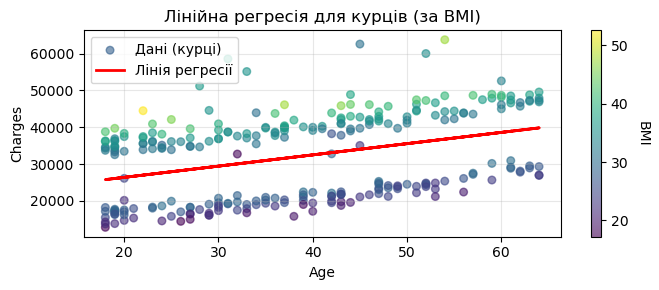

In [33]:
plt.figure(figsize=(7, 3))

# scatter plot з кольором по BMI
scatter = plt.scatter(X, y, c=smoker_df['bmi'], cmap='viridis', 
                     label='Дані (курці)', alpha=0.6, s=30)

cbar = plt.colorbar(scatter)
cbar.set_label('BMI', rotation=270, labelpad=15)

plt.plot(X, y_pred, color='red', label='Лінія регресії', linewidth=2)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Лінійна регресія для курців (за BMI)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

З графіка видно, менші витрати мають пацієнти з меншим індексом маси тіла. Пацієнти з більшим ІМТ - мають більші медичні витрати. Спробуємо розбити на 2 підгрупи по ІМТ та апроксимувати їх лінійною залежністю.

In [60]:
#дані з курцями, у яких нормальний BMI
smoker_df_norm_bmi = medical_df[(medical_df.smoker == 'yes') & (medical_df.bmi < 30)]

X = smoker_df_norm_bmi['age'].values.reshape(-1, 1)
y = smoker_df_norm_bmi['charges'].values

In [61]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [62]:
y_pred = model.predict(X)

In [63]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("Коефіцієнти моделі norm_bmi:")
print("  Intercept beta_0:", model.intercept_)
print("  Slope beta_1:", model.coef_[0])
print(f"\nТочність моделі norm_bmi:")
print(f"  RMSE: {rmse:.2f}")
print(f"  R^2: {r2:.4f}")

Коефіцієнти моделі norm_bmi:
  Intercept beta_0: 11503.356357662233
  Slope beta_1: 260.6397592052401

Точність моделі norm_bmi:
  RMSE: 3633.16
  R^2: 0.4818


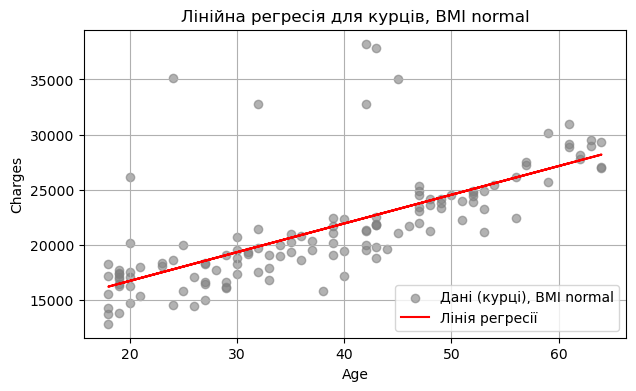

In [64]:
plt.figure(figsize=(7, 4))
plt.scatter(X, y, color='grey', label='Дані (курці), BMI normal', alpha=0.6)

plt.plot(X, y_pred, color='red', label='Лінія регресії')
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Лінійна регресія для курців, BMI normal")
plt.legend()
plt.grid()
plt.show()

In [65]:
#дані з курцями BMI high
smoker_df_high_bmi = medical_df[(medical_df.smoker == 'yes') & (medical_df.bmi >= 30)]

X = smoker_df_high_bmi['age'].values.reshape(-1, 1)
y = smoker_df_high_bmi['charges'].values

In [66]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [67]:
y_pred = model.predict(X)

In [68]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("Коефіцієнти моделі high_bmi:")
print("  Intercept beta_0:", model.intercept_)
print("  Slope beta_1:", model.coef_[0])
print(f"\nТочність моделі high_bmi:")
print(f"  RMSE: {rmse:.2f}")
print(f"  R^2: {r2:.4f}")

Коефіцієнти моделі high_bmi:
  Intercept beta_0: 30558.127017499064
  Slope beta_1: 281.1528484474945

Точність моделі high_bmi:
  RMSE: 4477.15
  R^2: 0.4452


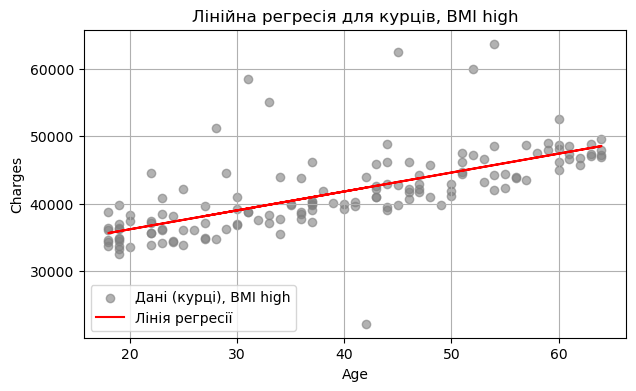

In [69]:
plt.figure(figsize=(7, 4))
plt.scatter(X, y, color='grey', label='Дані (курці), BMI high', alpha=0.6)

plt.plot(X, y_pred, color='red', label='Лінія регресії')
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Лінійна регресія для курців, BMI high")
plt.legend()
plt.grid()
plt.show()

Висновки:
- Точність моделі norm_bmi: RMSE: 3633.16, R^2: 0.4818
- Точність моделі high_bmi: RMSE: 4477.15, R^2: 0.4452
- В цілому такий підхід не ідеальний, але RMSE зменшився у ~2.5-3 рази, а R^2 збільшився з ~0.14 до ~0.45-0.48 (майже в 4 рази). Тож розбиття на підгрупи покращило модель.